In [81]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(a, eps0, tau, t_e):
    return eps0 * np.exp(-(a - t_e) / tau)

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):

    if a < t_e - delta:
        return hill_survival_function(a, mu_ub, mu_lb, K, m)
    
    elif t_e - delta <= a <= t_e:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, delta-(t_e-a))
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)
    
    else:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), a-t_e, a-t_e+delta)
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau) for a in ages])

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or delta < 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def find_dip(sector):
    from survival_analysis import obtain_survival_fractions, obtain_total_alive_count

    sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
    parameters = [
        [0.13660027, 0.03574423, 12.39113424, 4.14356328],
        [0.10877533, 0.0418096, 12.55269306, 4.41391222],
        [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
        [0.13090805, 0.03791174, 11.9429807, 4.05657508],
        [0.070120134, 0.011071032, 17.60063205, 11.71975389],
        [0.10301031, 0.04128293, 9.26045477, 8.13925264],
        [0.190143914, 0.028016019, 6.93767599, 100],
        [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
        [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
        [0.12568692, 0.03447114, 17.44283135, 5.60609428],
        [0.121213526, 0.068684245, 9.44518567, 100],
        [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
        [0.078301599, 0.047197935, 7.79197632, 100],
        [0.132289514, 0.085485775, 8.85732298, 100]
    ]
    sector_params_MLE = dict(zip(sector_list, parameters))

    _, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    mu_ub, mu_lb, K, m = sector_params_MLE[sector]
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = survivors * np.log(S_vals) + deaths * np.log(1 - S_vals)

    minlogL_ages = ages[np.argsort(logL)[:9]]
    max_count = 0
    best_cluster = []

    for i in range(len(minlogL_ages)):
        # Find all points within window of minlogL_ages[i]
        cluster = minlogL_ages[(minlogL_ages >= minlogL_ages[i]) & (minlogL_ages <= minlogL_ages[i] + 0.5)]
        if len(cluster) > max_count:
            max_count = len(cluster)
            best_cluster = cluster

    return float(np.mean(best_cluster)) if len(best_cluster) > 0 else None


def fit_hill_with_dip(ages, survivors, totals, initial_guess = [0.05, 0.1, 7, 10, 8, 2.5, 3, 0.8]):
    from scipy.optimize import minimize

    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 8),      # delta
        (0.1, 30),    # eps0
        (0.01, 30)      # tau
    ]
    result = minimize(neg_ll_hill_with_dip, initial_guess, args=(ages, survivors, totals), bounds=bounds)

    return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

In [2]:
from survival_analysis import prepare_df
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


Fitted parameters (with dip):
mu_ub: 0.11555052725787383, mu_lb: 0.06802543565439674, K: 6.28151448827344, m: 9.857046612774358, t_e: 7.399999994978641, delta: 2.258860201858482, eps0: 3.4390450728837187, tau: 1.5014303322016382
AIC (with dip): 83317.78278673897


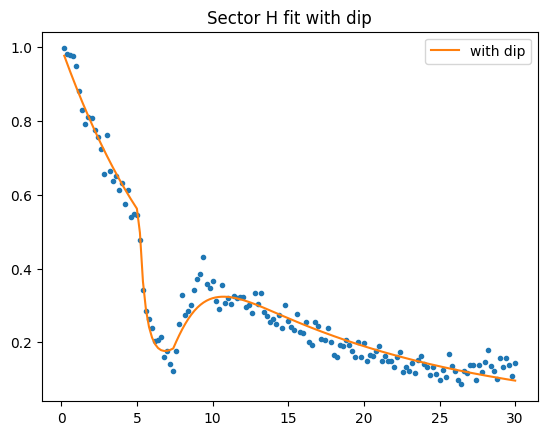

In [63]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.13, 0.1, 7, 10, 7.5, 2.5, 4, 1]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 10),       # t_e
    (0.1, 8),      # delta
    (0.1, 10),    # eps0
    (0.01, 10)      # tau
]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}")
aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f"AIC (with dip): {aic_with_dip}")

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

# 83318

Fitted parameters (with dip):
mu_ub: 0.13575519212976267, mu_lb: 1e-06, K: 13.525053258611646, m: 5.606747499329119, t_e: 8.418296932535482, delta: 0.418294550919262, eps0: 7.373614767616914, tau: 0.22382933175241462
AIC (with dip): 71384.85706185756


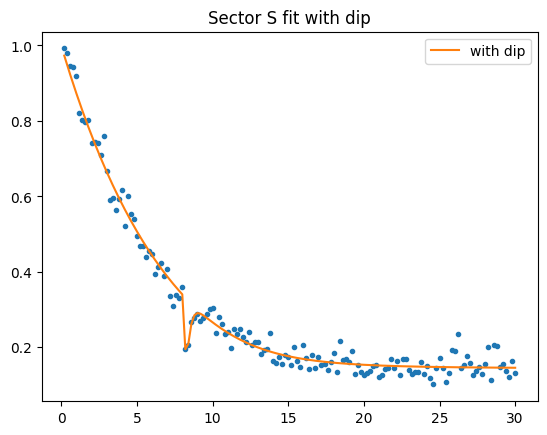

In [83]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'S')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'S')
from scipy.optimize import minimize

initial_guess = [0.13, 0.05, 10, 5, 8, 0.5, 8, 0.4]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 15),       # t_e
    (0.1, 8),      # delta
    (0.01, 20),    # eps0
    (0.1, 30)      # tau
]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}")
aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f"AIC (with dip): {aic_with_dip}")

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.13660027, 0.03574423, 12.39113424, 4.14356328), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector S fit with dip')
plt.legend()
plt.show()

In [8]:
print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

mu_lb: 1e-06, mu_ub: 0.13704259756217294, K: 13.290350822751982, m: 5.401760623468965, t_e: 8.384432962829331, delta: 0.38061318650338605, eps0: 8.833118154985302, tau: 0.23305975296383738


AIC for sector G
with dip: 395498.34404120164, original: 396775.65376669867
Parameters for sector G
mu_lb: 0.05676991838026777, mu_ub: 0.13038468334634004, K: 11.154304824365887, m: 10.155997341157503, t_e: 8.383443799546807, delta: 0.4079736056240589, eps0: 10.156196457219357, tau: 0.38131274423138756


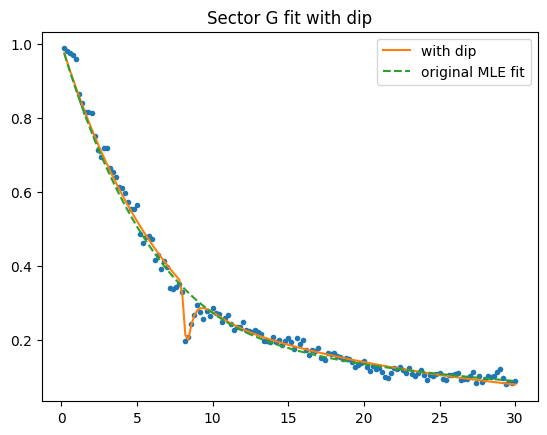

AIC for sector M
with dip: 213569.00652534614, original: 213844.85279567266
Parameters for sector M
mu_lb: 0.055853323131800636, mu_ub: 0.10647202939276267, K: 11.55390482596968, m: 10.026936130207737, t_e: 8.259261481205023, delta: 0.29415192890446057, eps0: 9.94658193163718, tau: 0.4887693731397878


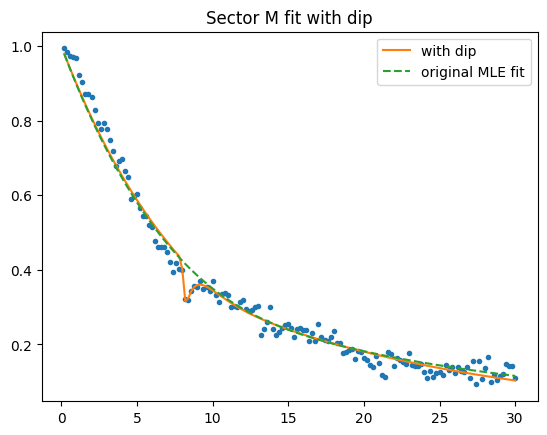

AIC for sector F
with dip: 95561.11671098278, original: 95543.98775340038
Parameters for sector F
mu_lb: 0.074532677898945, mu_ub: 0.0817329704270596, K: 6.640413902213468, m: 10.055217180458307, t_e: 6.599973336359121, delta: 0.11635336232001803, eps0: 9.310793489700739, tau: 1.970259041106047


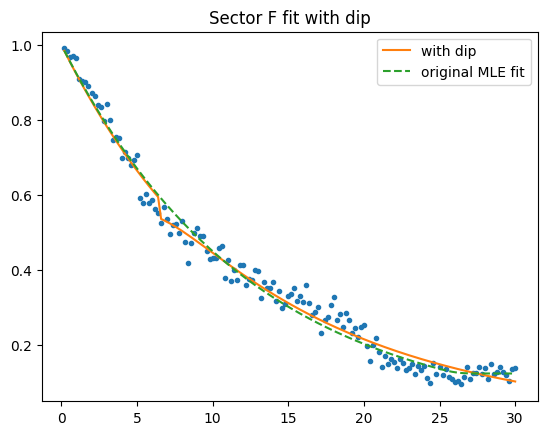

AIC for sector J
with dip: 113879.72902828475, original: 113998.28886457565
Parameters for sector J
mu_lb: 0.055652892195009726, mu_ub: 0.12994319163333026, K: 9.903105978478658, m: 9.960204181280849, t_e: 8.24285480910736, delta: 0.2643437957964349, eps0: 9.989696390368204, tau: 0.30043314415131783


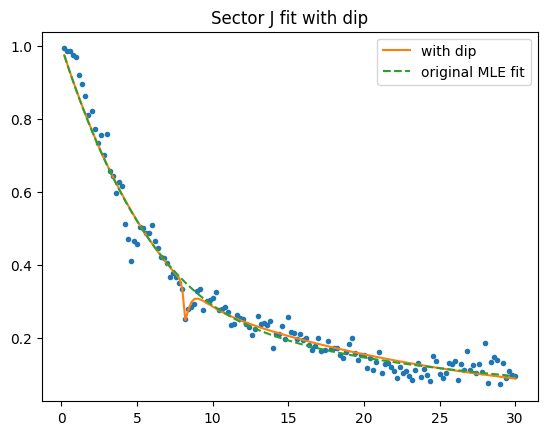

AIC for sector K
with dip: 112208.19269670843, original: 112433.7547568274
Parameters for sector K
mu_lb: 0.013029050175442198, mu_ub: 0.06321879199037081, K: 18.828932882387768, m: 9.963304861809338, t_e: 7.863291318913988, delta: 1.8003240094144424, eps0: 1.1832006941972357, tau: 30.0


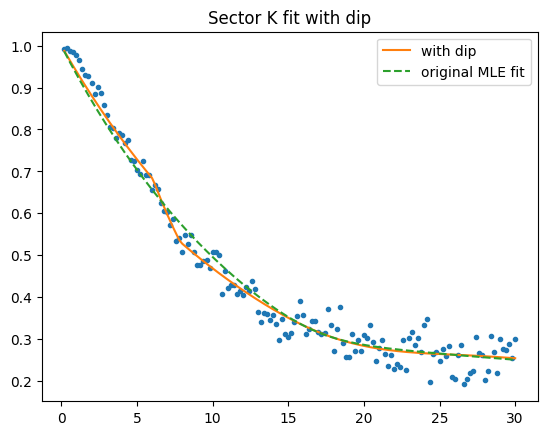

AIC for sector C
with dip: 79059.04282709115, original: 79121.45006331938
Parameters for sector C
mu_lb: 0.04882356572085876, mu_ub: 0.09962770680025511, K: 8.746396616267134, m: 34.398614691612934, t_e: 8.384755434216896, delta: 0.22529548005020755, eps0: 10.019584781328145, tau: 0.11545616256854743


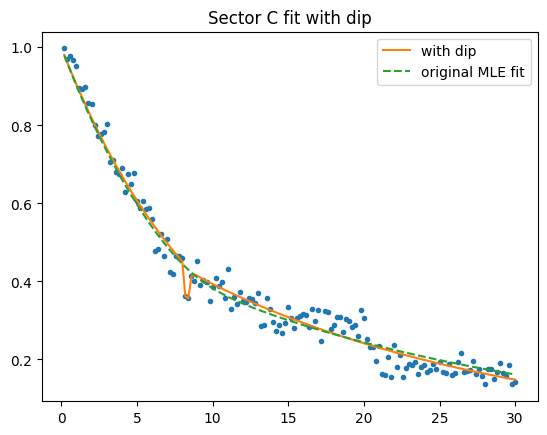

AIC for sector H
with dip: 83403.5355727809, original: 85957.7009922323
Parameters for sector H
mu_lb: 0.0681079178924771, mu_ub: 0.12083605558618403, K: 6.218307771226611, m: 10.010871930889227, t_e: 7.399999991111479, delta: 2.2415598798666574, eps0: 2.6677759697519763, tau: 1.1954438723766025


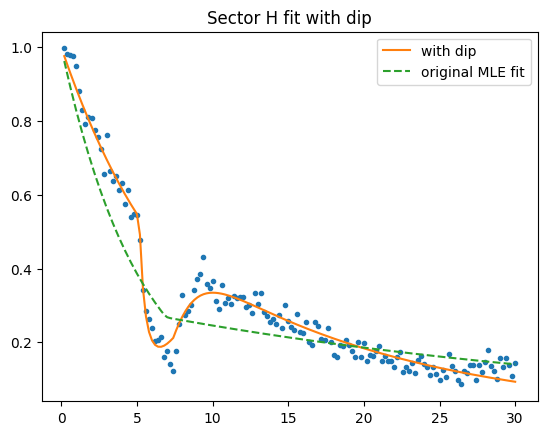

AIC for sector S
with dip: 71400.08770811898, original: 71512.5738700587
Parameters for sector S
mu_lb: 0.006791094484921199, mu_ub: 0.13478433223752403, K: 13.207024275454142, m: 9.828270029940656, t_e: 8.36221002423846, delta: 0.3622100165227731, eps0: 9.832812784050887, tau: 0.2608953444954222


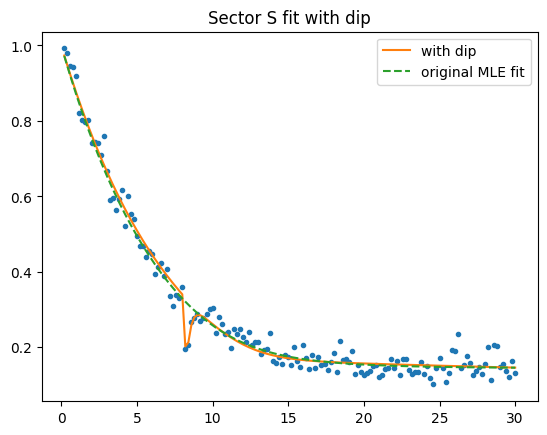

AIC for sector N
with dip: 73876.43306997852, original: 74032.64426437464
Parameters for sector N
mu_lb: 1e-06, mu_ub: 0.11966095142470551, K: 16.896731823730526, m: 4.290860815844768, t_e: 8.400000132399693, delta: 0.4114556771030629, eps0: 8.810275531119625, tau: 0.2611041601661008


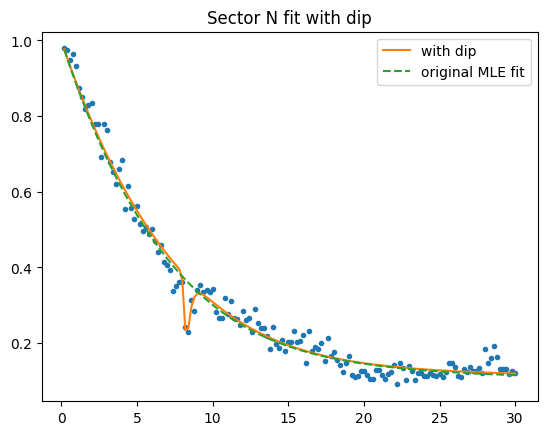

AIC for sector I
with dip: 68463.1363985949, original: 68509.00744804495
Parameters for sector I
mu_lb: 0.01664035023505077, mu_ub: 0.12314377807194275, K: 19.325045271417288, m: 9.974089571564978, t_e: 8.433157311788142, delta: 0.269062649077907, eps0: 9.852927969709047, tau: 0.1308993693867998


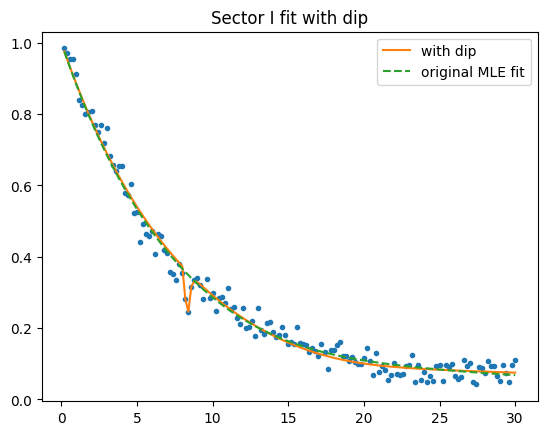

AIC for sector P
with dip: 50284.894064552944, original: 50319.80915016665
Parameters for sector P
mu_lb: 0.068721932205798, mu_ub: 0.11794998997326837, K: 9.62966727288519, m: 10.065599185599295, t_e: 8.153634172683475, delta: 0.20195352814500486, eps0: 9.996083647744092, tau: 1.3208854616278887


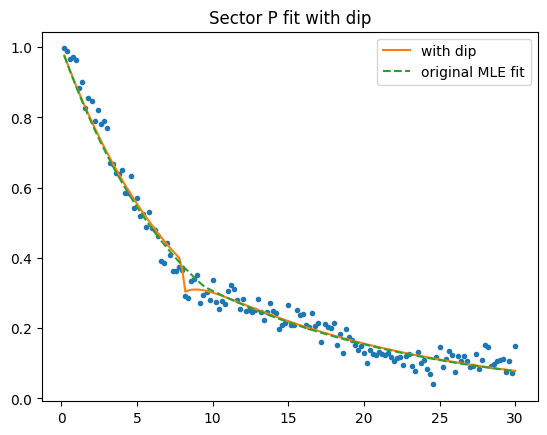

AIC for sector L
with dip: inf, original: 23846.6358313165
Parameters for sector L
mu_lb: 0.07809518625088803, mu_ub: 0.06935640078572484, K: 7.0372047074049755, m: 9.99540237534509, t_e: 7.06802255365999, delta: 0.39441778202746974, eps0: 9.900012426940501, tau: 0.7237779945699165


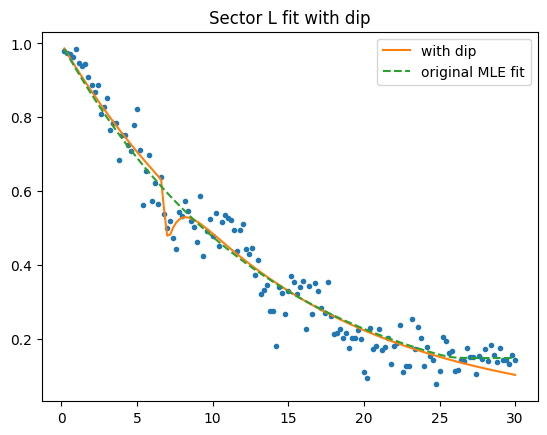

AIC for sector Q
with dip: 25778.410703893598, original: 25785.161680934158
Parameters for sector Q
mu_lb: 0.049328159109206536, mu_ub: 0.07824472460096958, K: 6.904104660290985, m: 10.088426116147518, t_e: 8.350094929088433, delta: 0.2751414835741497, eps0: 9.910682810847629, tau: 0.4415295749523217


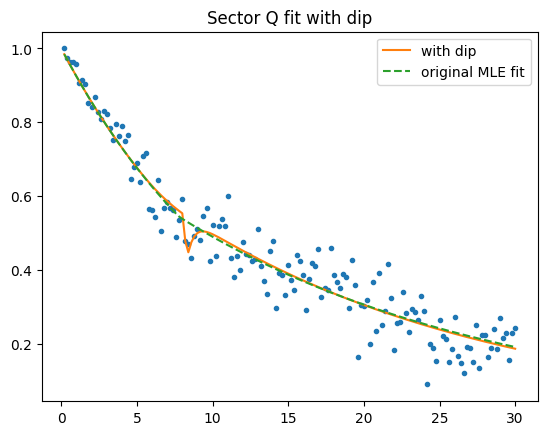

AIC for sector R
with dip: 15043.765283436636, original: 15047.29190362784
Parameters for sector R
mu_lb: 0.08847526953741004, mu_ub: 0.13053655005418355, K: 8.073938227009032, m: 10.256239039585994, t_e: 8.315548844601864, delta: 0.19999049178444733, eps0: 9.99667158014105, tau: 1.4512448676722176


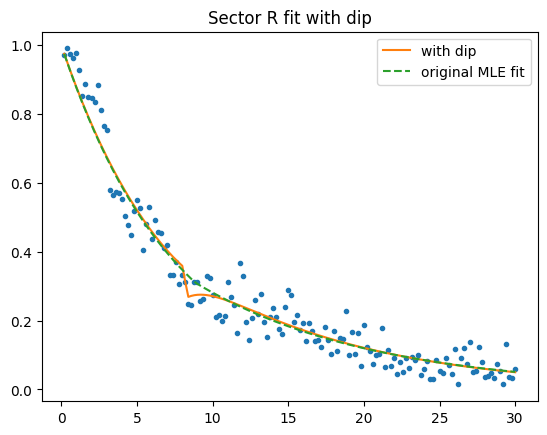

In [27]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.05, 0.1, 9, 10, 8, 0.3, 10, 0.4], [0.05, 0.1, 7, 10, 8, 2.5, 10.0, 1.0]
    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 8),      # delta
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    result1 = minimize(lsq_hill_with_dip, initial_guess1, args=(ages, survival_fractions), bounds=bounds)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    result2 = minimize(lsq_hill_with_dip, initial_guess2, args=(ages, survival_fractions), bounds=bounds)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

AIC for sector G
with dip: 396405.5527029811, original: 396775.65376669867
Parameters for sector G
mu_lb: 0.05, mu_ub: 0.13, K: 11.0, m: 5.0, t_e: 8.0, delta: 0.5, eps0: 8.0, tau: 0.5


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


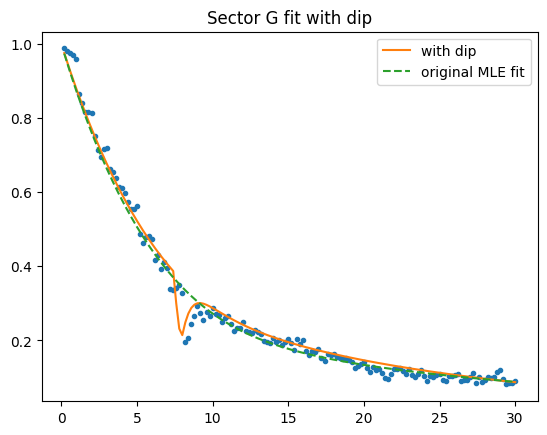

AIC for sector M
with dip: 213578.4338434662, original: 213844.85279567266
Parameters for sector M
mu_lb: 0.04786311962629725, mu_ub: 0.10275505554698075, K: 13.806905188879922, m: 6.174161325688105, t_e: 7.966839500087439, delta: 0.2610173856703313, eps0: 9.937135507836269, tau: 1.199685802487916


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


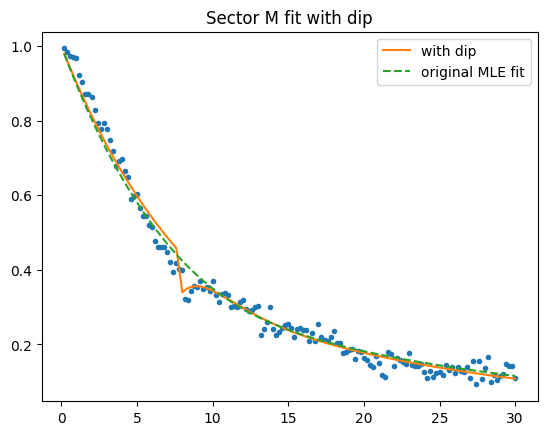

AIC for sector F
with dip: 95555.97923201858, original: 95543.98775340038
Parameters for sector F
mu_lb: 0.07599944916479355, mu_ub: 0.08118453316090504, K: 7.738907645602695, m: 3.6613009382411836, t_e: 8.483731607251384, delta: 0.3002384436876212, eps0: 5.634444317502331, tau: 0.11652487813848911


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


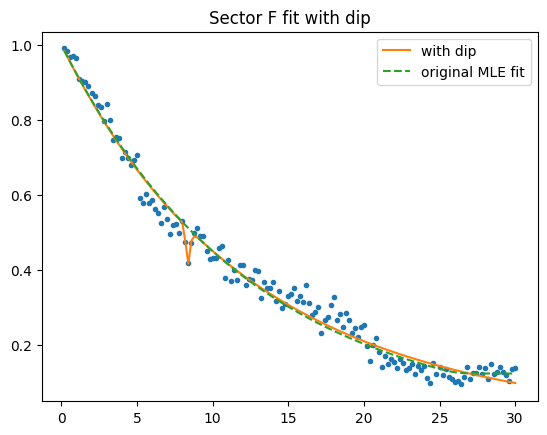

AIC for sector J
with dip: 113870.17361204431, original: 113998.28886457565
Parameters for sector J
mu_lb: 0.0501560221337738, mu_ub: 0.12789234554552295, K: 11.035516225052717, m: 5.016455356357192, t_e: 8.286825617407306, delta: 0.33482216692769634, eps0: 8.020569899914182, tau: 0.3768696704121298


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


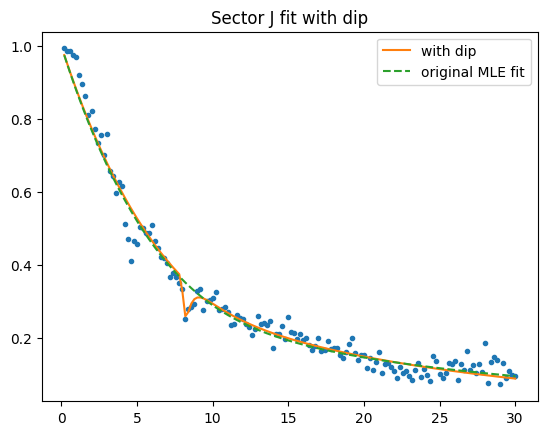

KeyboardInterrupt: 

In [86]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.13, 0.05, 11, 5, 8, 0.5, 8, 0.5], [0.13, 0.1, 7, 10, 7.5, 2.5, 4, 1]
    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 4),      # delta
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    result1 = fit_hill_with_dip(ages, survivors, totals, initial_guess1)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    result2 = fit_hill_with_dip(ages, survivors, totals, initial_guess2)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

WITHOUT DELTA

In [88]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(a, eps0, tau, t_e):
    return eps0 * np.exp(-abs(a - t_e) / tau)

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau):

    # if a < t_e:
    #     return hill_survival_function(a, mu_ub, mu_lb, K, m)
    
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau) for a in ages])

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def fit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 6, 10, 5, 1, 1]):
    from scipy.optimize import minimize

    bounds = [
        (0.01, 0.3),   # mu_ub
        (0.01, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    result = minimize(neg_ll_hill_with_dip, initial_guess, args=(ages, survivors, totals), bounds=bounds)

    return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, eps0, tau = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

Fitted parameters (with dip):
mu_ub: 0.12539073022734232, mu_lb: 0.0454108635231017, K: 13.269467351475127, m: 6.0084991676110215, t_e: 8.323362164897672, eps0: 0.5294331927963155, tau: 0.6161329644805773
AIC = 395471.53134703776


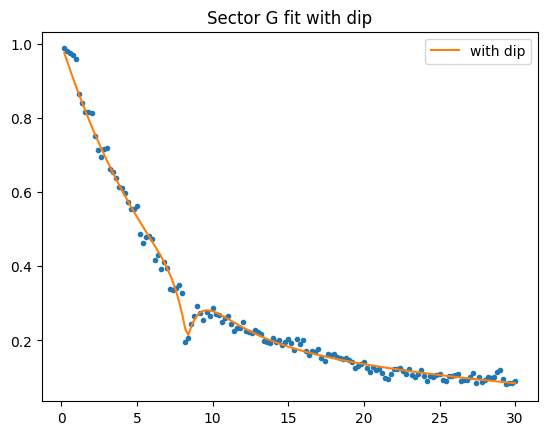

In [ ]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'G')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'G')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.13, 0.07, 10, 5, 8.2, 0.5, 0.3]
bounds = [
    (0.01, 0.3),   # mu_ub
    (0.01, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 10),       # t_e
    (0.1, 20),    # eps0
    (0.01, 30)      # tau
]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}")

aic_with_dip = 2 * 7 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector G fit with dip')
plt.legend()
plt.show()

# AIC for sector G
# with dip: 395498.34404120164, original: 396775.65376669867

Fitted parameters (with dip):
mu_ub: 0.09633603800118264, mu_lb: 0.01862949486157865, K: 19.99034937155565, m: 4.979919526984387, t_e: 6.6602284501883275, eps0: 2.387701945138309, tau: 1.119701960316073
AIC = 83501.75838740736


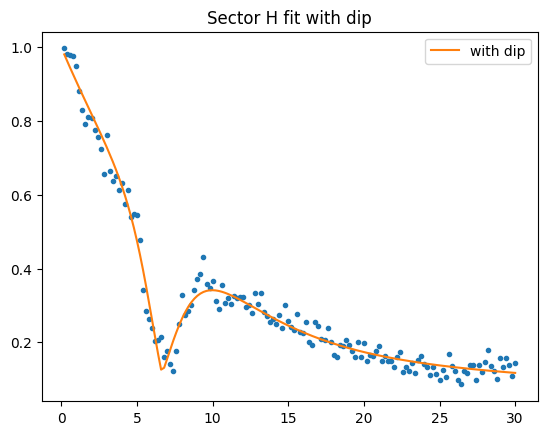

In [49]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.11, 0.08, 20, 5, 7, 2.2, 0.7]
bounds = [
    (0.01, 0.3),   # mu_ub
    (0.01, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 10),       # t_e
    (0.1, 20),    # eps0
    (0.01, 30)      # tau
]
result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
# result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}")

aic_with_dip = 2 * 7 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

# Fitted parameters (with dip):
# mu_ub: 0.11555052725787383, mu_lb: 0.06802543565439674, K: 6.28151448827344, m: 9.857046612774358, t_e: 7.399999994978641, delta: 2.258860201858482, eps0: 3.4390450728837187, tau: 1.5014303322016382
# AIC (with dip): 83317.78278673897

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
C:\Users\chong\AppData\Local\Temp\ipykernel_12964\2272864606.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
c:\Users\chong\OneDrive\Documents\GitHub\a-star\hill.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)


AIC for sector G
with dip: 411525.0350399745, original: 396775.65376669867
Parameters for sector G
mu_lb: 0.1, mu_ub: 0.1, K: 10.0, m: 5.0, t_e: 8.6, eps0: 3.0, tau: 1.0


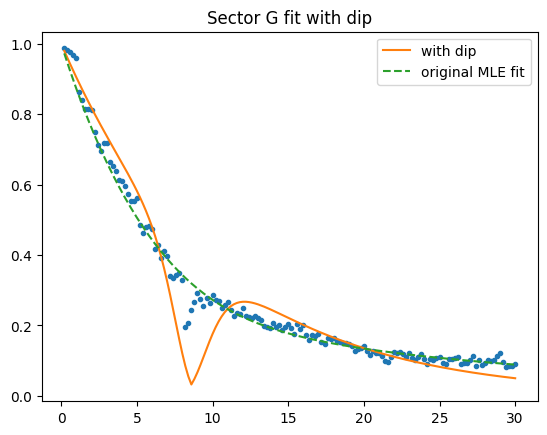

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
C:\Users\chong\AppData\Local\Temp\ipykernel_12964\2272864606.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
c:\Users\chong\OneDrive\Documents\GitHub\a-star\hill.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)


KeyboardInterrupt: 

In [91]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.05, 0.12, 10, 5, find_dip(sector), 0.5, 0.3], [0.1, 0.1, 10, 5, find_dip(sector), 3.0, 1.0]
    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    # result1 = minimize(lsq_hill_with_dip, initial_guess1, args=(ages, survival_fractions), bounds=bounds)
    result1 = fit_hill_with_dip(ages, survivors, totals, initial_guess1)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    # result2 = minimize(lsq_hill_with_dip, initial_guess2, args=(ages, survival_fractions), bounds=bounds)
    result2 = fit_hill_with_dip(ages, survivors, totals, initial_guess2)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, eps0, tau = result.x

    aic_with_dip = 2 * 7 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()